In [2]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os
import gc

print("📥 Оптимизированная загрузка Parquet файла...")

# Путь к файлу
file_path = "/kaggle/input/sbolpro_merged_final.pqt"

# Сначала посмотрим на схему данных
table = pq.read_table(file_path, columns=['timestamp'])  # Только для анализа
print(f"Общее количество строк: {table.num_rows:,}")

# Метод 1: Загрузка с фильтрацией через PyArrow
def load_with_filter():
    """Загрузка с фильтрацией на уровне чтения"""
    print("\n🔍 Фильтрация на уровне чтения...")
    
    # Определяем границы дат
    import pyarrow.compute as pc
    
    # Читаем только колонку timestamp для фильтрации
    timestamps = pq.read_table(file_path, columns=['timestamp']).column('timestamp')
    
    # Преобразуем в datetime и фильтруем
    timestamps_dt = pd.to_datetime(timestamps.to_pandas())
    
    # Создаем маску для исключения мая 2023
    mask = ~((timestamps_dt.dt.year == 2023) & (timestamps_dt.dt.month == 5))
    
    print(f"Оставляем {mask.sum():,} строк из {len(mask):,}")
    
    # Загружаем данные с фильтрацией
    # Читаем файл по частям с фильтрацией
    batch_size = 100000
    filtered_chunks = []
    
    # Используем ParquetDataset для чтения с предикатами
    dataset = pq.ParquetFile(file_path)
    
    for i in range(0, table.num_rows, batch_size):
        # Читаем батч
        batch = dataset.read_row_group(i // dataset.metadata.num_row_groups if i > 0 else 0)
        batch_df = batch.to_pandas()
        
        # Применяем фильтр
        batch_df['timestamp'] = pd.to_datetime(batch_df['timestamp'])
        batch_df['year_month'] = batch_df['timestamp'].dt.strftime('%Y-%m')
        filtered = batch_df[batch_df['year_month'] != '2023-05']
        
        if len(filtered) > 0:
            filtered_chunks.append(filtered)
        
        # Очистка памяти
        if i % (batch_size * 10) == 0:
            gc.collect()
            print(f"Обработано {i:,} строк...")
    
    # Объединяем результаты
    result = pd.concat(filtered_chunks, ignore_index=True)
    print(f"✅ Загружено с фильтрацией: {len(result):,} строк")
    
    return result

# Метод 2: Загрузка только нужных колонок с оптимизацией типов
def load_optimized():
    """Загрузка с оптимизацией типов"""
    print("\n🎯 Загрузка с оптимизацией типов...")
    
    # Определяем типы данных для каждой колонки
    column_types = {
        'product_id': 'category',
        'user_id': 'category', 
        'is_sold': 'int8',
        # Остальные числовые колонки будем оптимизировать
    }
    
    # Сначала читаем небольшую выборку для анализа типов
    sample = pq.read_table(file_path).slice(0, 10000).to_pandas()
    
    # Анализируем числовые колонки
    for col in sample.select_dtypes(include=['float64']).columns:
        if col not in column_types:
            column_types[col] = 'float32'
    
    for col in sample.select_dtypes(include=['int64']).columns:
        if col not in column_types:
            min_val = sample[col].min()
            max_val = sample[col].max()
            if min_val >= 0:  # Беззнаковый
                if max_val < 256:
                    column_types[col] = 'uint8'
                elif max_val < 65536:
                    column_types[col] = 'uint16'
                elif max_val < 4294967296:
                    column_types[col] = 'uint32'
            else:  # Знаковый
                if min_val > -128 and max_val < 127:
                    column_types[col] = 'int8'
                elif min_val > -32768 and max_val < 32767:
                    column_types[col] = 'int16'
                elif min_val > -2147483648 and max_val < 2147483647:
                    column_types[col] = 'int32'
    
    print(f"Оптимизированные типы для {len(column_types)} колонок")
    
    # Загружаем с оптимизированными типами
    data = pd.read_parquet(
        file_path,
        columns=list(column_types.keys())  # Только нужные колонки
    )
    
    # Применяем оптимизированные типы
    for col, dtype in column_types.items():
        if col in data.columns:
            data[col] = data[col].astype(dtype)
    
    print(f"✅ Загружено: {len(data):,} строк, {data.memory_usage(deep=True).sum()/1024**2:.1f} MB")
    
    return data

# Метод 3: Итеративная обработка с немедленным удалением
def process_incremental():
    """Постепенная обработка с немедленным удалением ненужных данных"""
    print("\n🔄 Постепенная обработка...")
    
    # Читаем файл по частям
    batch_size = 50000
    result_chunks = []
    
    # Создаем ParquetFile объект
    pq_file = pq.ParquetFile(file_path)
    
    for i, batch in enumerate(pq_file.iter_batches(batch_size=batch_size)):
        df_batch = batch.to_pandas()
        
        # Немедленная фильтрация
        df_batch['timestamp'] = pd.to_datetime(df_batch['timestamp'])
        df_batch['year_month'] = df_batch['timestamp'].dt.strftime('%Y-%m')
        
        # Удаляем май 2023
        df_batch = df_batch[df_batch['year_month'] != '2023-05']
        
        if len(df_batch) > 0:
            # Оптимизируем типы
            for col in df_batch.select_dtypes(include=['float64']).columns:
                df_batch[col] = df_batch[col].astype('float32')
            
            result_chunks.append(df_batch)
        
        # Очистка памяти после каждого батча
        del df_batch
        gc.collect()
        
        if i % 20 == 0:
            print(f"Обработано {(i+1)*batch_size:,} строк...")
    
    # Объединяем результаты
    if result_chunks:
        result = pd.concat(result_chunks, ignore_index=True)
        print(f"✅ Итоговый размер: {len(result):,} строк")
        return result
    else:
        print("⚠️  Нет данных после фильтрации")
        return pd.DataFrame()

# Выбираем метод в зависимости от размера данных
try:
    # Пробуем самый эффективный метод
    data = process_incremental()
except MemoryError:
    print("Недостаточно памяти, пробуем более легкий метод...")
    data = load_optimized()
except Exception as e:
    print(f"Ошибка: {e}")
    print("Пробуем альтернативный метод...")
    data = load_optimized()

📥 Оптимизированная загрузка Parquet файла...
Общее количество строк: 1,056,889

🔄 Постепенная обработка...
Обработано 50,000 строк...
Обработано 1,050,000 строк...
✅ Итоговый размер: 1,051,557 строк


In [3]:
data.head(5)

,timestamp,user_id,product_id,is_sold,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_1336,feature_1337,feature_1338,feature_1339,feature_1340,feature_1341,feature_1342,feature_1343,feature_1344,year_month
0,2023-01-15,1010508,1,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-1.030499,-0.234190,-0.244455,0.269814,2023-01
1,2023-01-15,1010508,2,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-1.030499,-0.234190,-0.244455,1.535497,2023-01
2,2023-01-15,1010508,10,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-1.030499,-0.234190,-0.244455,0.119081,2023-01
3,2023-01-15,1025935,2,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-0.863126,4.067207,-0.244455,1.535497,2023-01
4,2023-01-15,1025935,10,0,-0.361854,-0.172997,-0.134458,-0.18008,-0.230458,-0.201765,...,-0.155774,-0.123948,-0.188584,-0.372165,-0.325964,-0.863126,4.067207,-0.244455,0.119081,2023-01


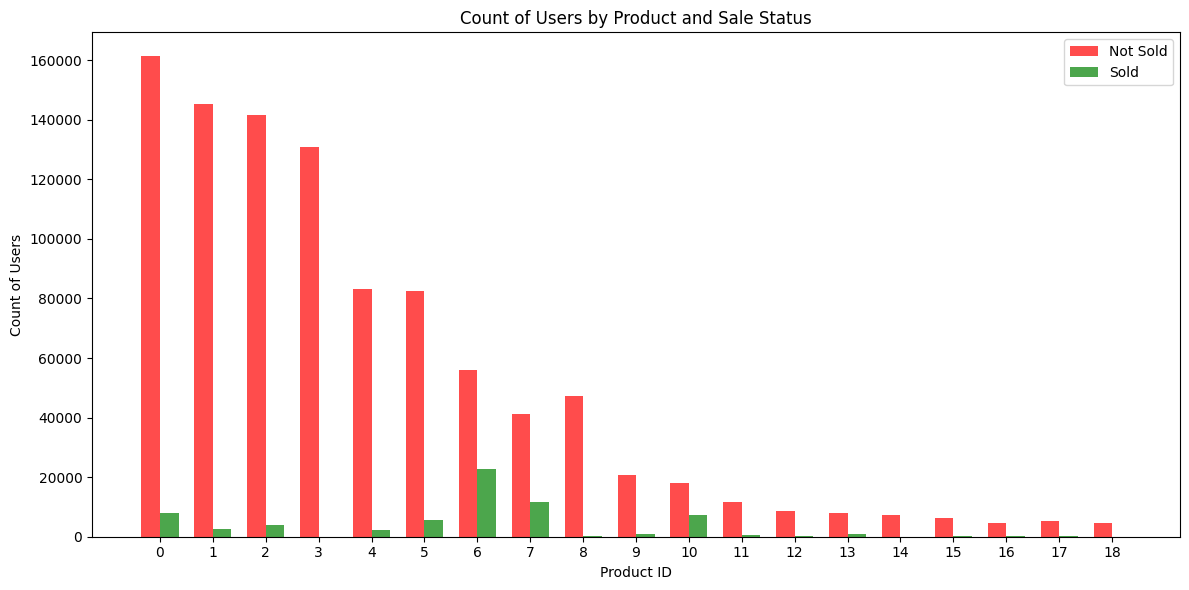

In [3]:
import numpy as np
import matplotlib.pyplot as plt
grouped_data = data[['product_id', 'is_sold', 'user_id']].groupby(['product_id', 'is_sold']).count()
grouped_data_reset = grouped_data.reset_index()
grouped_data_reset = grouped_data_reset.rename(columns={'user_id': 'count'})

# Преобразуем данные в широкий формат для сгруппированного отображения
pivot_data = grouped_data_reset.pivot(index='product_id', 
                                      columns='is_sold', 
                                      values='count').fillna(0)

# Создаем сгруппированный bar chart
plt.figure(figsize=(12, 6))

x = np.arange(len(pivot_data))
width = 0.35

# Бары для не проданных (is_sold = 0)
bars1 = plt.bar(x - width/2, pivot_data[0] if 0 in pivot_data.columns else [0]*len(pivot_data), 
                width, label='Not Sold', color='red', alpha=0.7)

# Бары для проданных (is_sold = 1)
bars2 = plt.bar(x + width/2, pivot_data[1] if 1 in pivot_data.columns else [0]*len(pivot_data), 
                width, label='Sold', color='green', alpha=0.7)

plt.xlabel('Product ID')
plt.ylabel('Count of Users')
plt.title('Count of Users by Product and Sale Status')
plt.xticks(x, pivot_data.index)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Группируем данные для расчета конверсии
conversion_data = data.groupby('product_id')['is_sold'].agg(
    total_interactions='count',
    total_sales='sum'
).reset_index()

# Рассчитываем конверсию
conversion_data['conversion_rate'] = (conversion_data['total_sales'] / 
                                      conversion_data['total_interactions']) * 100
conversion_data['conversion_rate_pct'] = conversion_data['conversion_rate'].round(2)

# Сортируем по конверсии
conversion_data_sorted = conversion_data.sort_values('conversion_rate', ascending=False)

conversion_data_sorted[['product_id', 'total_interactions', 'total_sales', 'conversion_rate_pct']].reset_index()

,index,product_id,total_interactions,total_sales,conversion_rate_pct
0,10,10,25304,7323,28.94
1,6,6,78634,22630,28.78
2,7,7,52910,11648,22.01
3,13,13,8835,1012,11.45
4,5,5,88337,5719,6.47
5,11,11,12231,665,5.44
6,16,16,4926,245,4.97
7,0,0,169141,7831,4.63
8,9,9,21531,894,4.15
9,17,17,5337,213,3.99


📊 ПОДГОТОВКА ДАННЫХ


/tmp/ipykernel_322/1127798309.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['year_month_str'] = data['timestamp'].dt.strftime('%Y-%m')


• Всего уникальных продуктов: 19
• Период анализа: 2023-01 - 2023-04
• Всего строк данных: 76

📈 ТОП-20 ПРОДУКТОВ ПО ПРОДАЖАМ:
 1. Продукт 6: 22,630 продаж за 4 месяцев
 2. Продукт 7: 11,648 продаж за 4 месяцев
 3. Продукт 0:  7,831 продаж за 4 месяцев
 4. Продукт 10:  7,323 продаж за 4 месяцев
 5. Продукт 5:  5,719 продаж за 4 месяцев
 6. Продукт 2:  3,955 продаж за 4 месяцев
 7. Продукт 1:  2,619 продаж за 4 месяцев
 8. Продукт 4:  2,264 продаж за 4 месяцев
 9. Продукт 13:  1,012 продаж за 4 месяцев
10. Продукт 9:    894 продаж за 4 месяцев
11. Продукт 11:    665 продаж за 4 месяцев
12. Продукт 16:    245 продаж за 4 месяцев
13. Продукт 17:    213 продаж за 4 месяцев
14. Продукт 15:    207 продаж за 4 месяцев
15. Продукт 8:    166 продаж за 4 месяцев
16. Продукт 12:     94 продаж за 4 месяцев
17. Продукт 14:     51 продаж за 4 месяцев
18. Продукт 18:     32 продаж за 4 месяцев
19. Продукт 3:     19 продаж за 4 месяцев

🚀 ВИЗУАЛИЗАЦИЯ ДИНАМИКИ ДЛЯ ТОП-10 ПРОДУКТОВ

 1. ВИЗУАЛИЗАЦИЯ ПР

/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


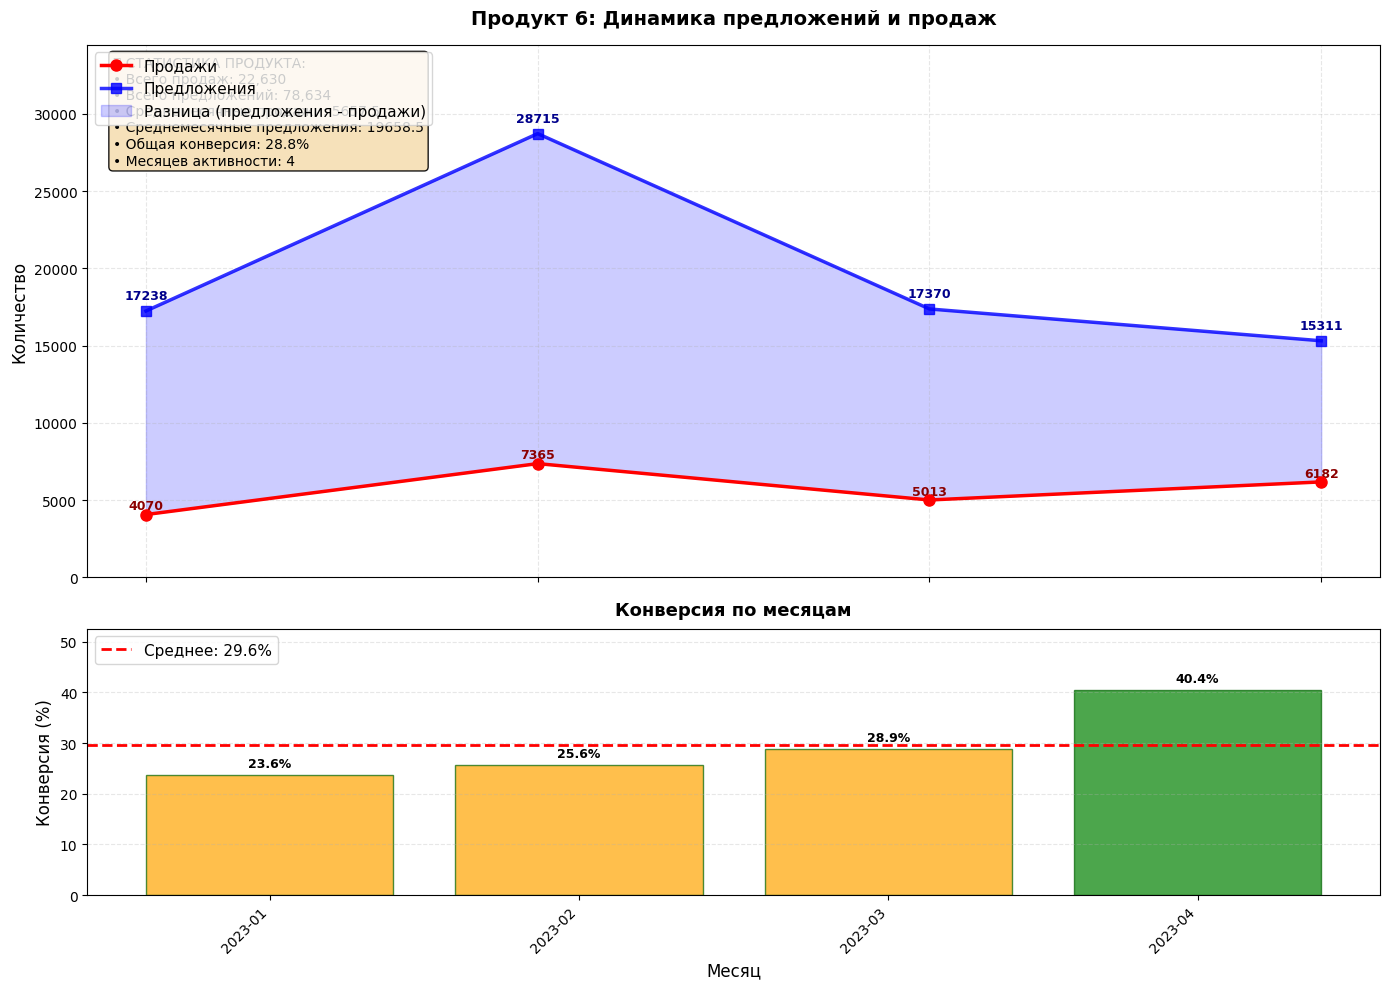


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 6
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          17,238      4,070        23.6%
2023-02          28,715      7,365        25.6%
2023-03          17,370      5,013        28.9%
2023-04          15,311      6,182        40.4%
--------------------------------------------------------------------------------
ИТОГО            78,634     22,630        28.8%
--------------------------------------------------------------------------------
Среднемесячно:    19658.5     5657.5        29.6%

 2. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 7
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


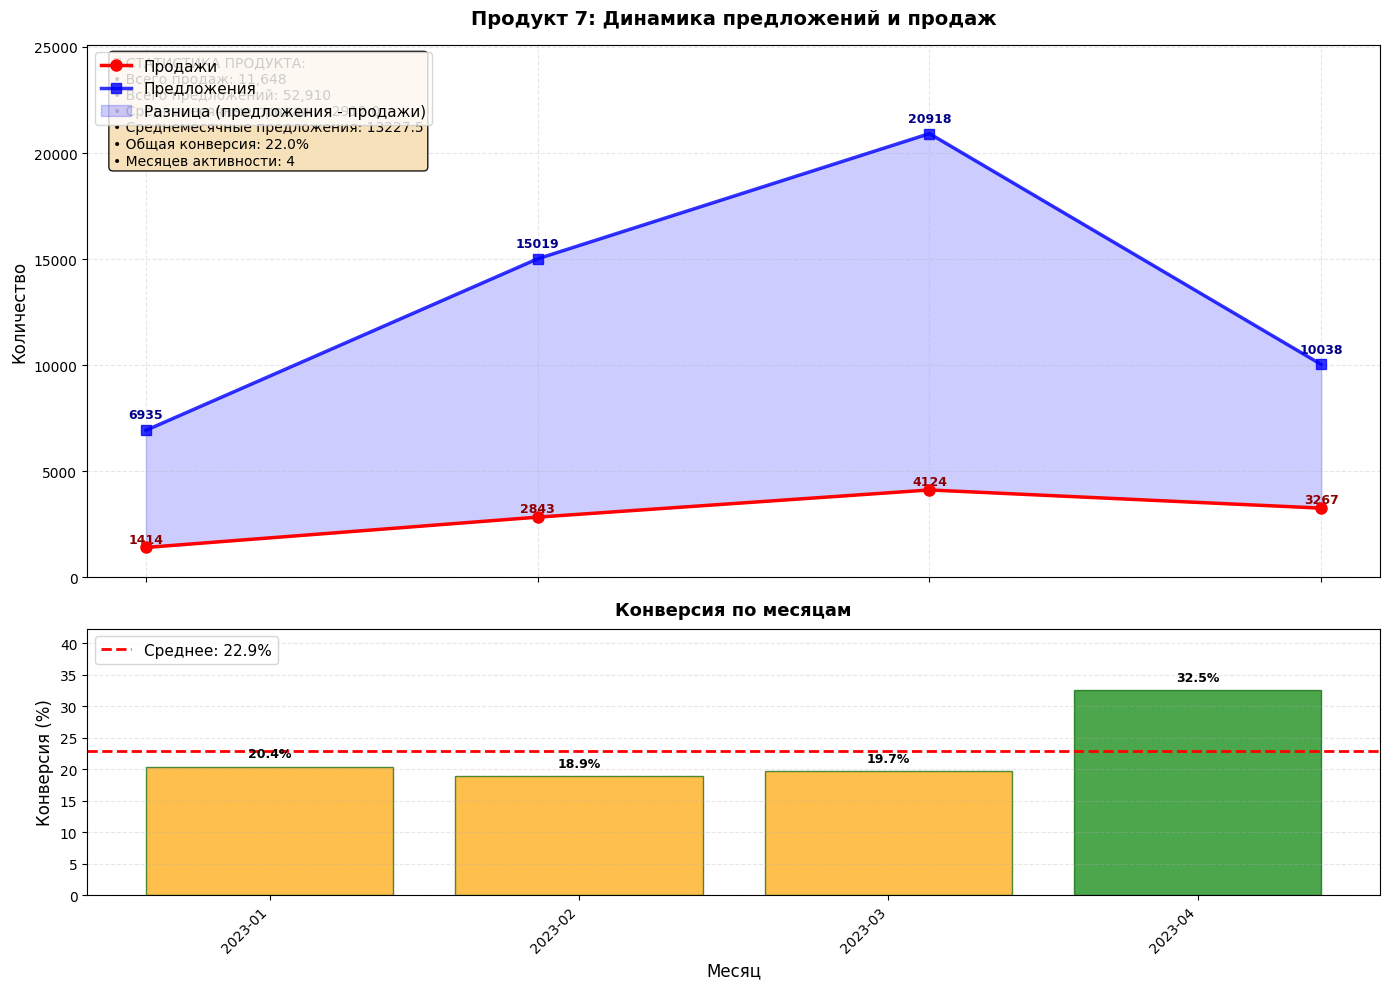


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 7
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01           6,935      1,414        20.4%
2023-02          15,019      2,843        18.9%
2023-03          20,918      4,124        19.7%
2023-04          10,038      3,267        32.5%
--------------------------------------------------------------------------------
ИТОГО            52,910     11,648        22.0%
--------------------------------------------------------------------------------
Среднемесячно:    13227.5     2912.0        22.9%

 3. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 0
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


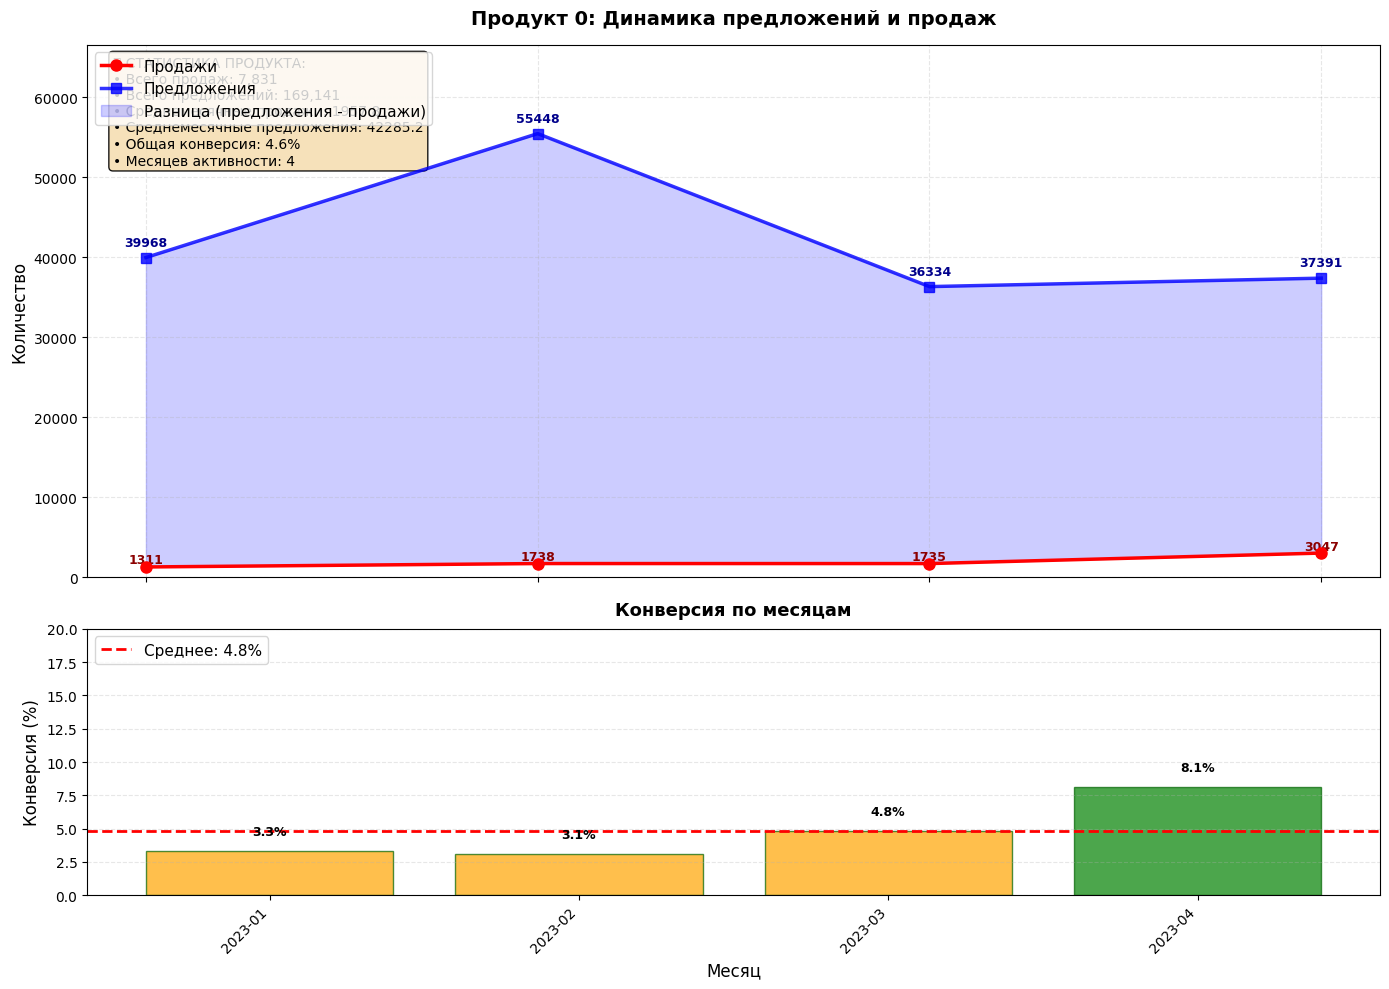


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 0
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          39,968      1,311         3.3%
2023-02          55,448      1,738         3.1%
2023-03          36,334      1,735         4.8%
2023-04          37,391      3,047         8.1%
--------------------------------------------------------------------------------
ИТОГО           169,141      7,831         4.6%
--------------------------------------------------------------------------------
Среднемесячно:    42285.2     1957.8         4.8%

 4. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 10
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


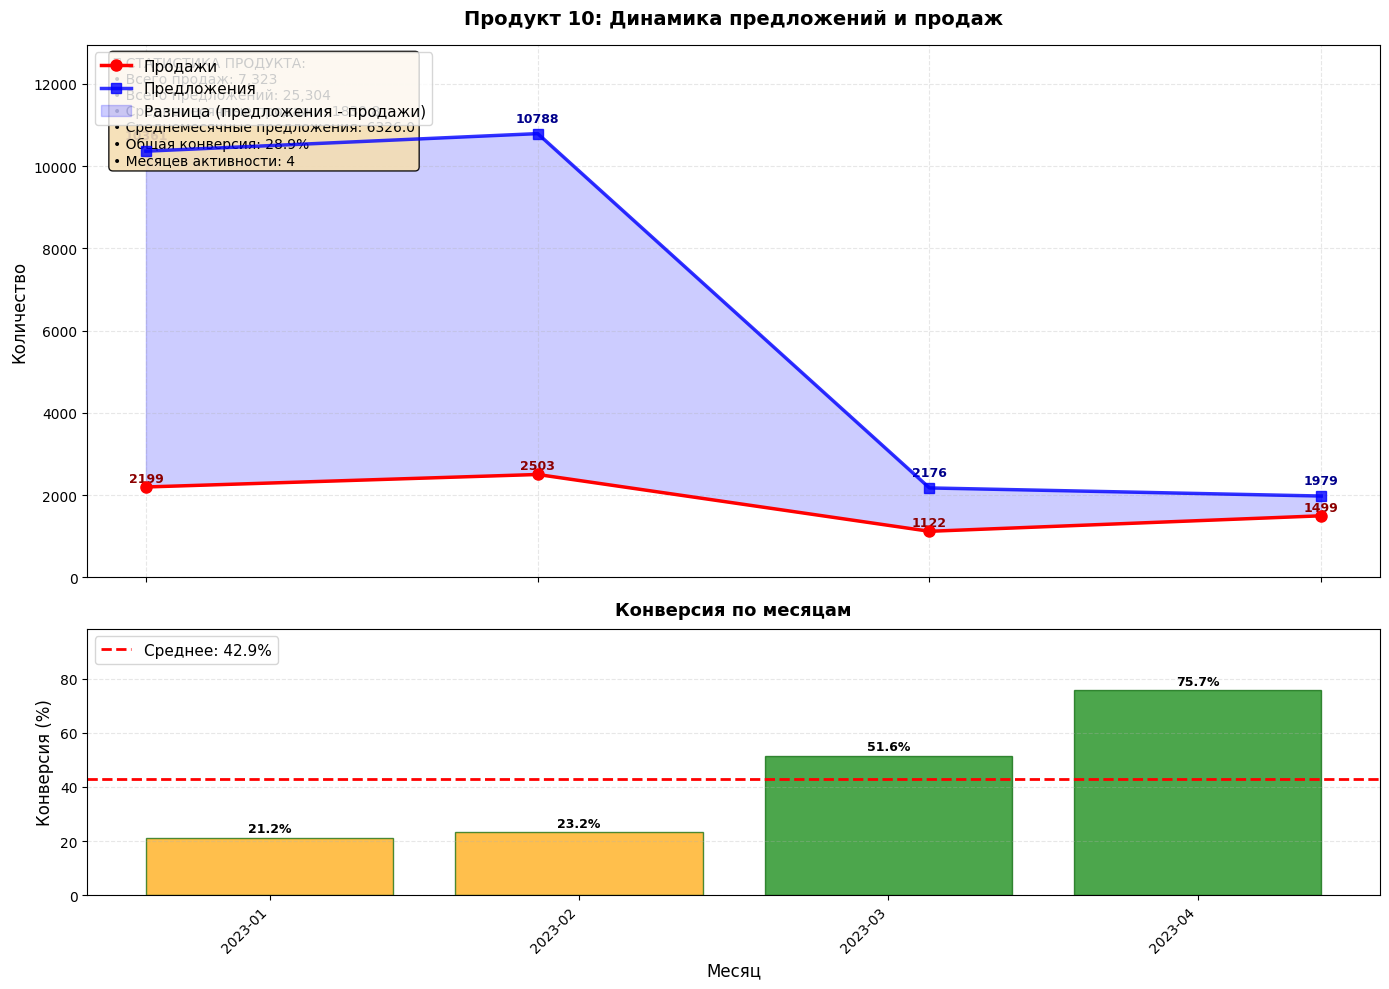


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 10
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          10,361      2,199        21.2%
2023-02          10,788      2,503        23.2%
2023-03           2,176      1,122        51.6%
2023-04           1,979      1,499        75.7%
--------------------------------------------------------------------------------
ИТОГО            25,304      7,323        28.9%
--------------------------------------------------------------------------------
Среднемесячно:     6326.0     1830.8        42.9%

 5. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 5
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


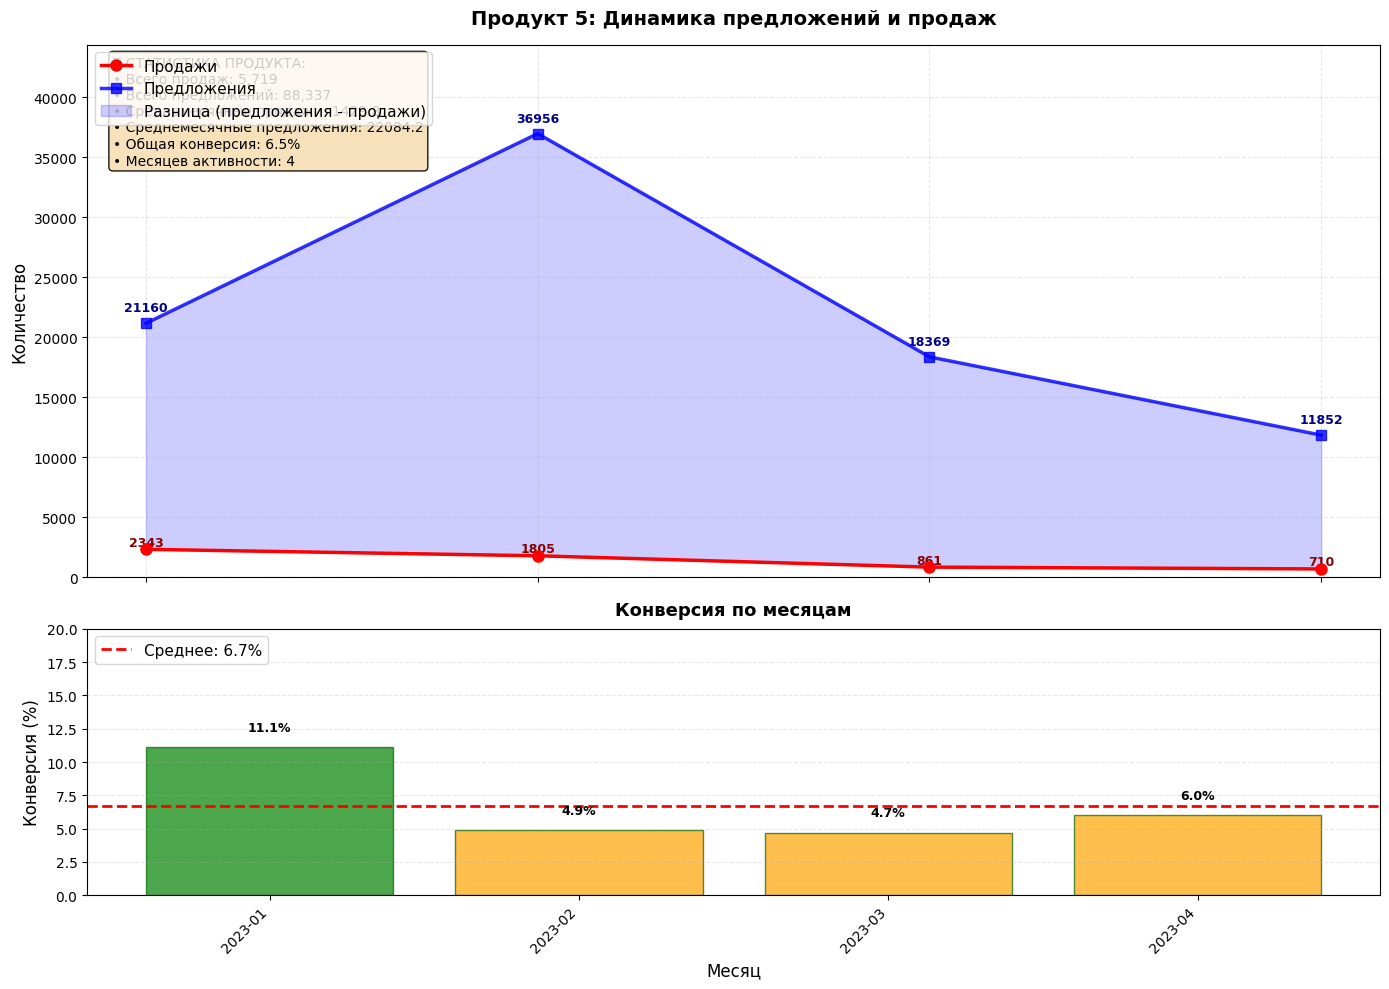


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 5
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          21,160      2,343        11.1%
2023-02          36,956      1,805         4.9%
2023-03          18,369        861         4.7%
2023-04          11,852        710         6.0%
--------------------------------------------------------------------------------
ИТОГО            88,337      5,719         6.5%
--------------------------------------------------------------------------------
Среднемесячно:    22084.2     1429.8         6.7%

 6. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 2
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


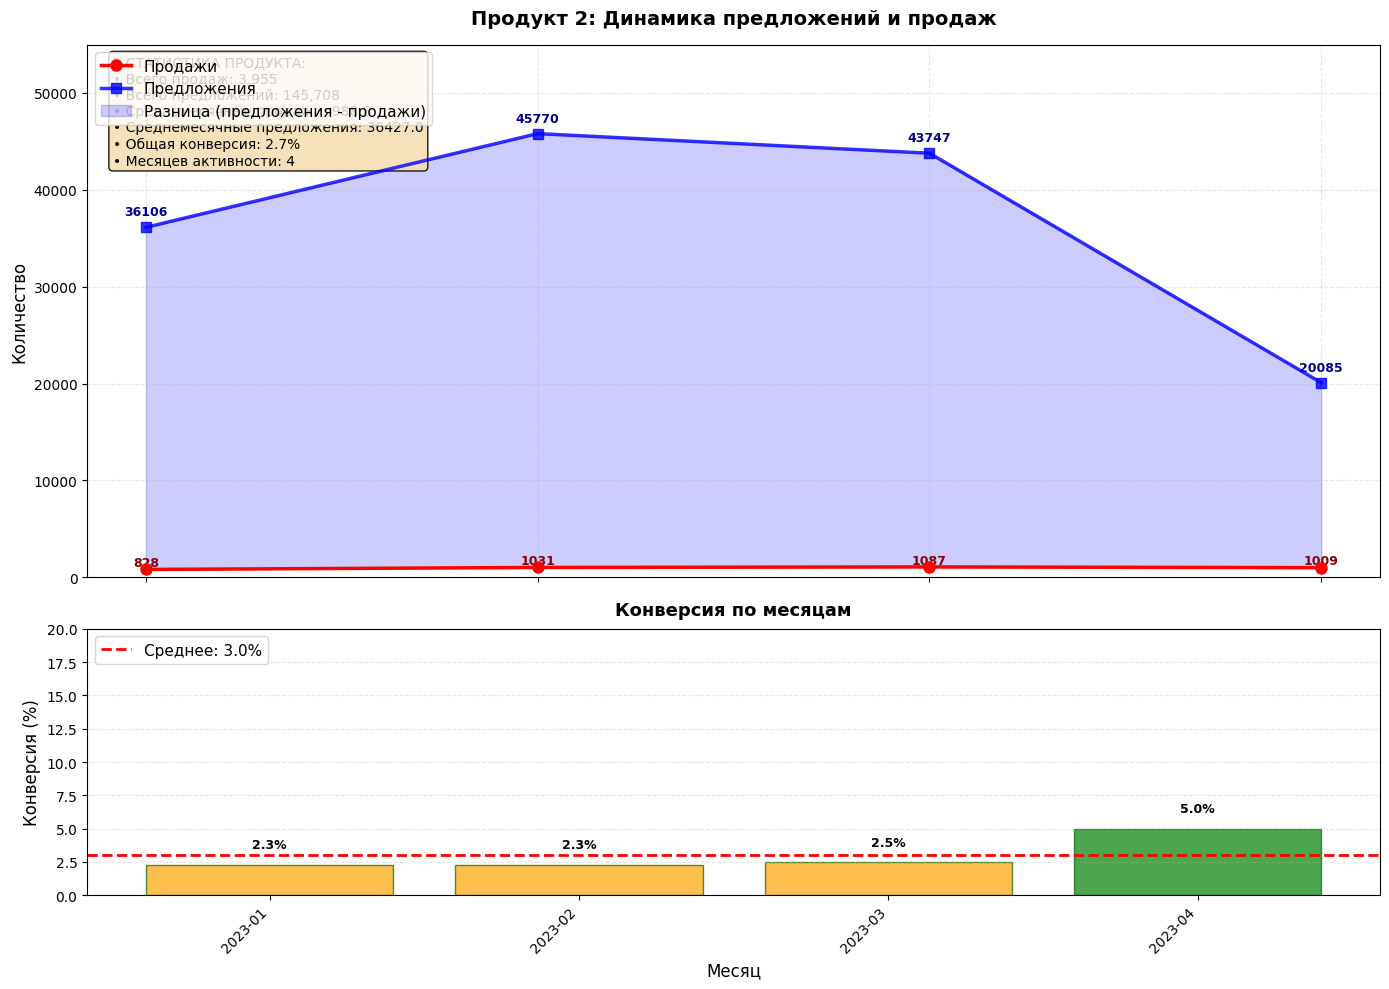


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 2
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          36,106        828         2.3%
2023-02          45,770      1,031         2.3%
2023-03          43,747      1,087         2.5%
2023-04          20,085      1,009         5.0%
--------------------------------------------------------------------------------
ИТОГО           145,708      3,955         2.7%
--------------------------------------------------------------------------------
Среднемесячно:    36427.0      988.8         3.0%

 7. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 1
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


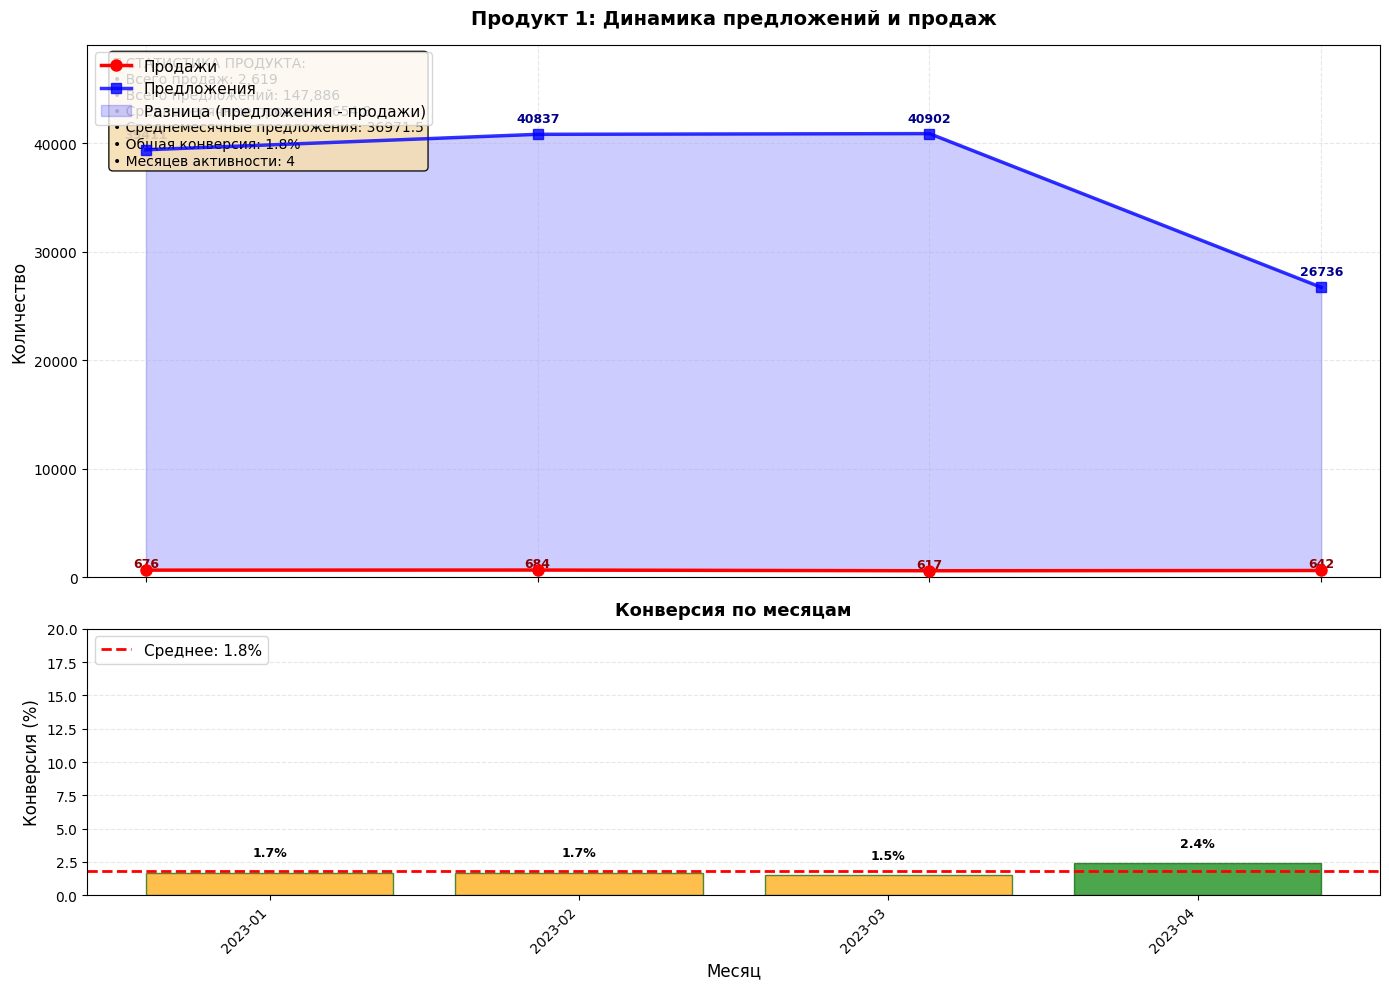


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 1
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          39,411        676         1.7%
2023-02          40,837        684         1.7%
2023-03          40,902        617         1.5%
2023-04          26,736        642         2.4%
--------------------------------------------------------------------------------
ИТОГО           147,886      2,619         1.8%
--------------------------------------------------------------------------------
Среднемесячно:    36971.5      654.8         1.8%

 8. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 4
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


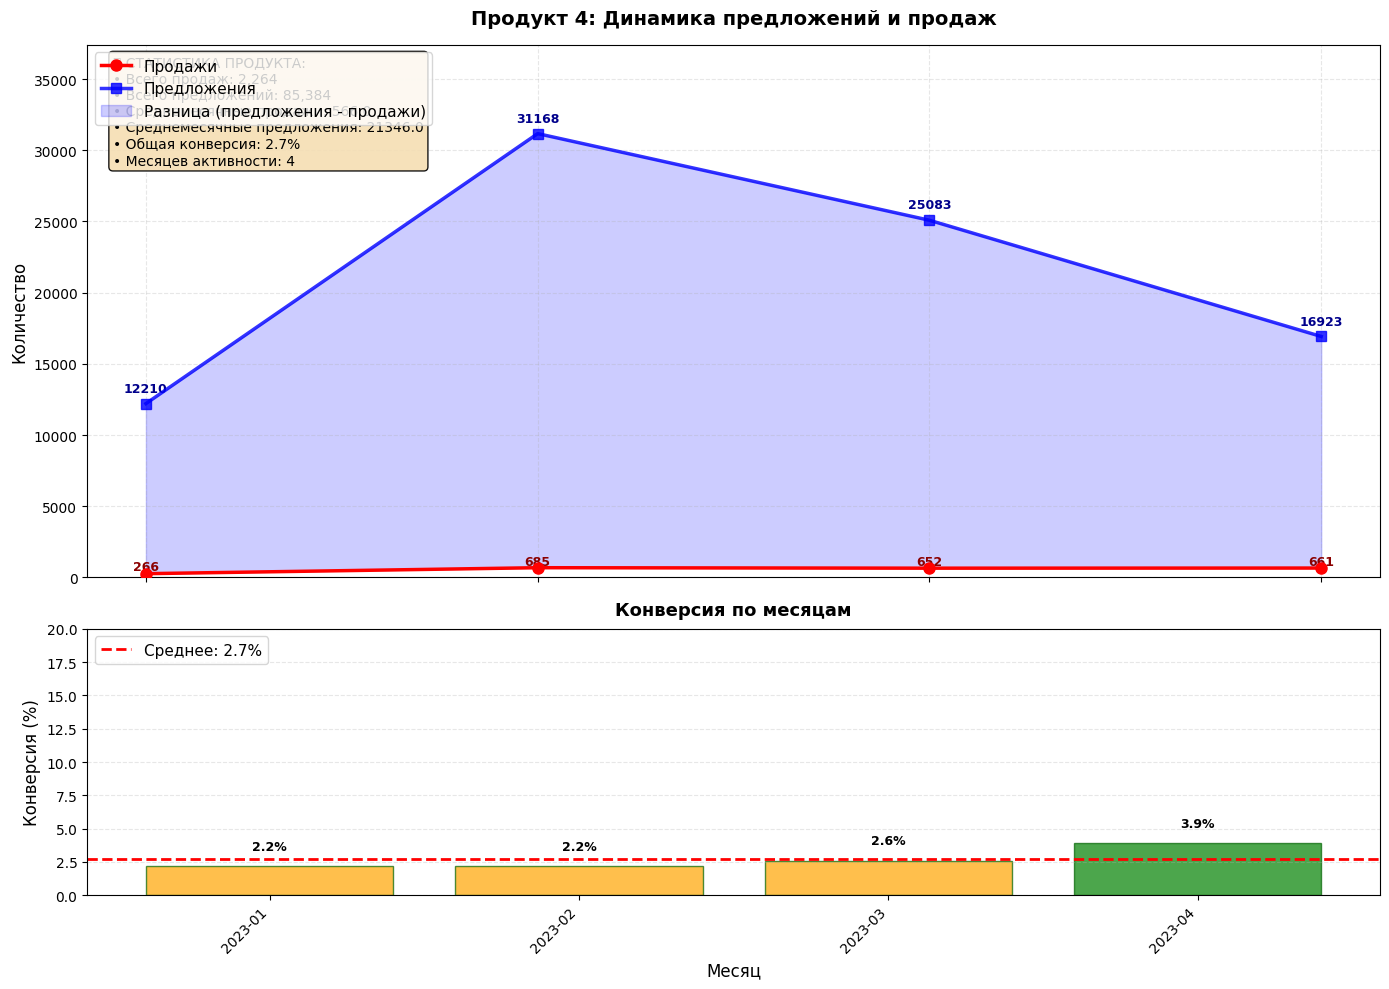


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 4
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01          12,210        266         2.2%
2023-02          31,168        685         2.2%
2023-03          25,083        652         2.6%
2023-04          16,923        661         3.9%
--------------------------------------------------------------------------------
ИТОГО            85,384      2,264         2.7%
--------------------------------------------------------------------------------
Среднемесячно:    21346.0      566.0         2.7%

 9. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 13
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


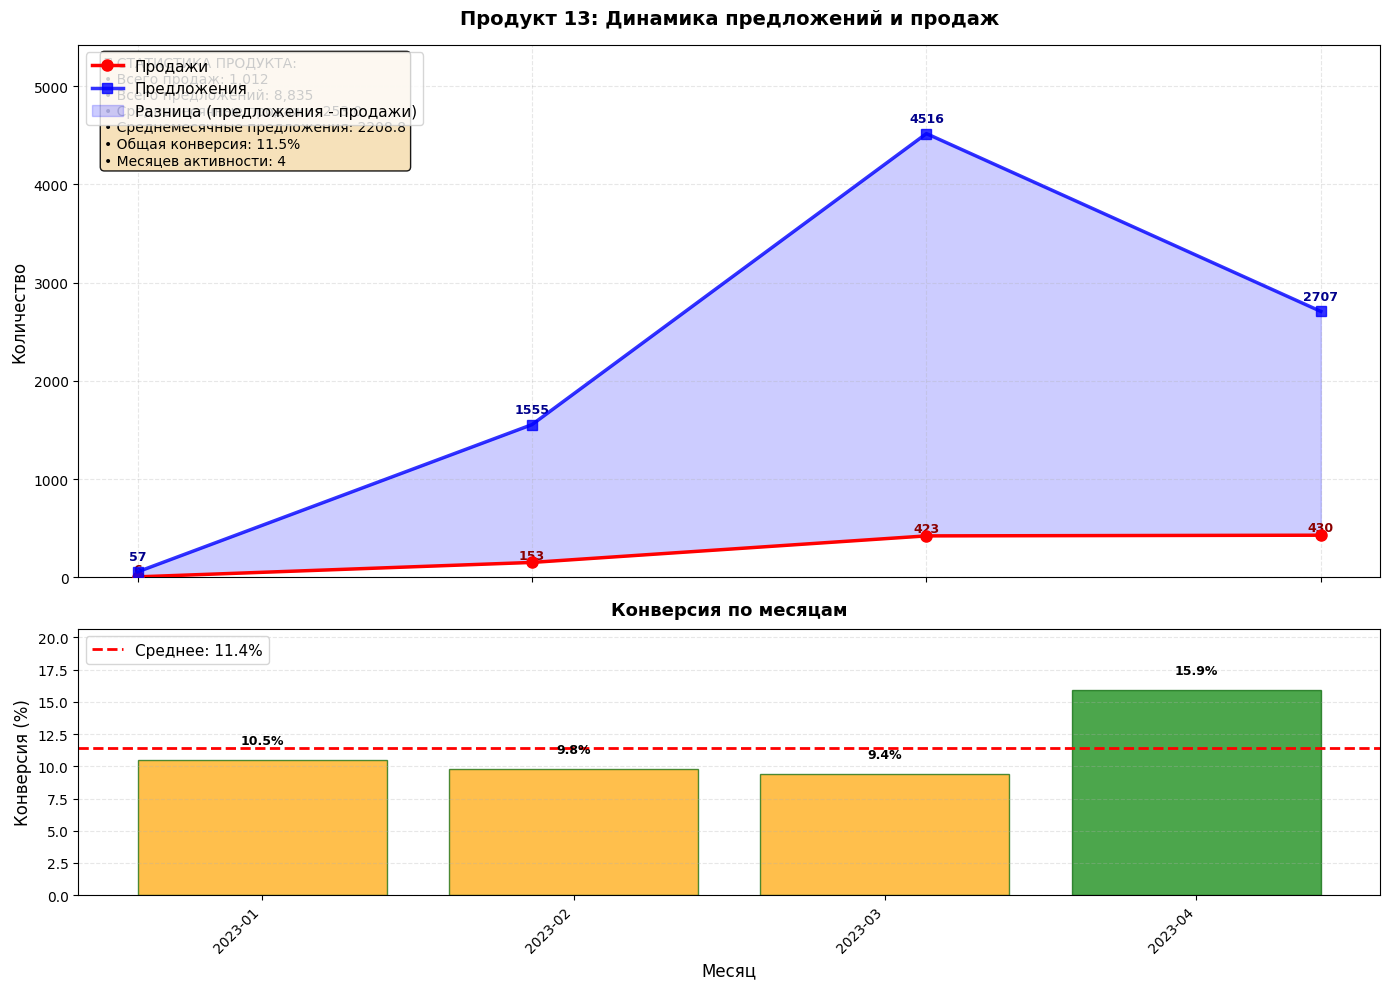


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 13
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01              57          6        10.5%
2023-02           1,555        153         9.8%
2023-03           4,516        423         9.4%
2023-04           2,707        430        15.9%
--------------------------------------------------------------------------------
ИТОГО             8,835      1,012        11.5%
--------------------------------------------------------------------------------
Среднемесячно:     2208.8      253.0        11.4%

10. ВИЗУАЛИЗАЦИЯ ПРОДУКТА 9
   ----------------------------------------


/tmp/ipykernel_322/1127798309.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


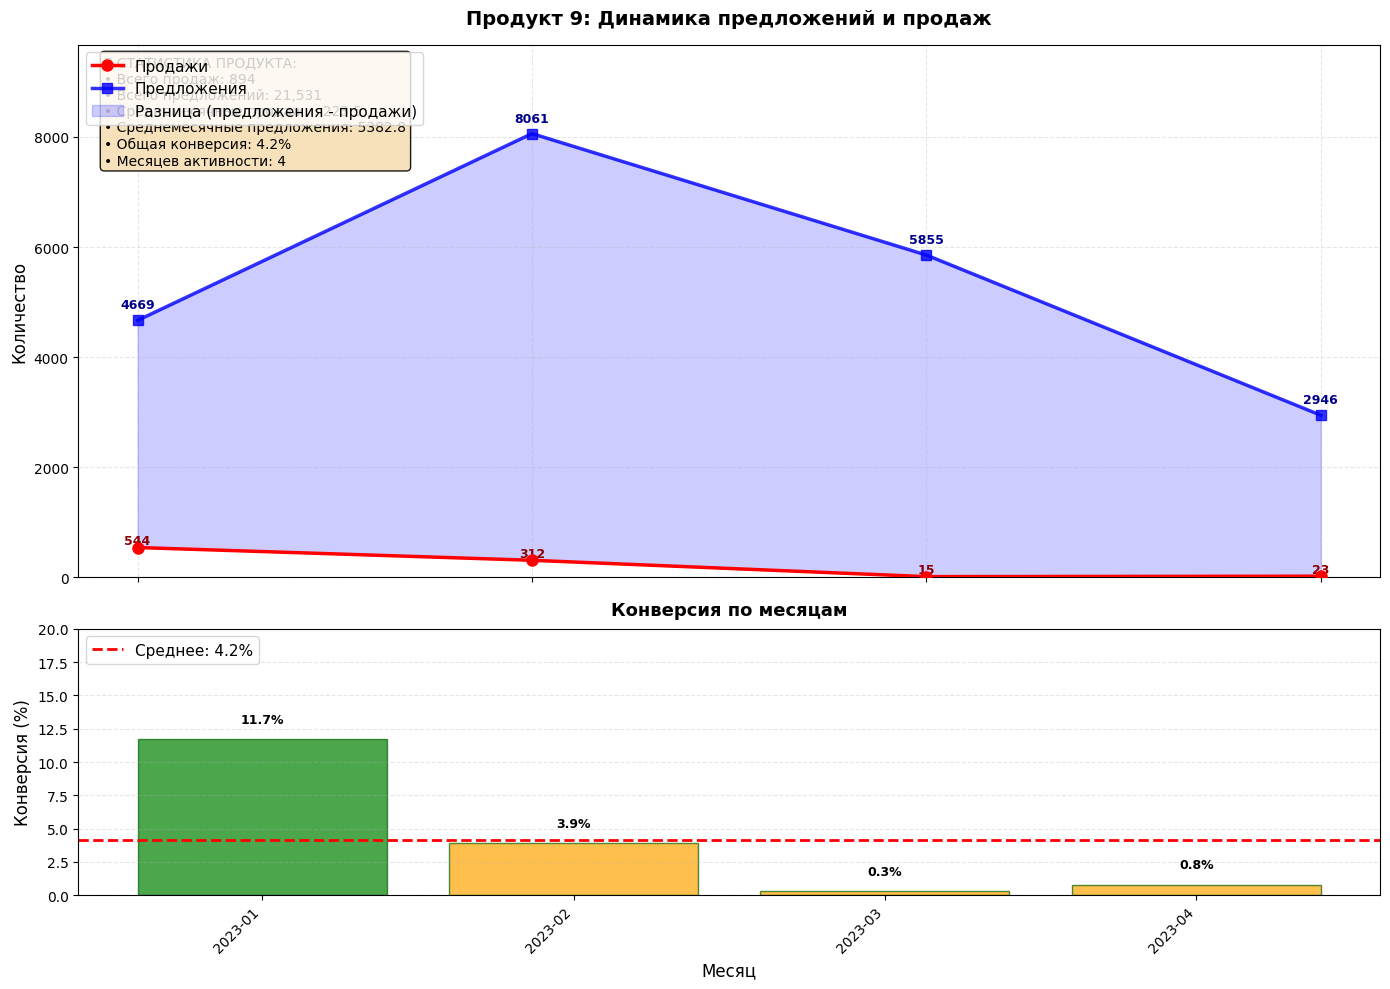


📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ 9
--------------------------------------------------------------------------------
Месяц       Предложения    Продажи    Конверсия
--------------------------------------------------------------------------------
2023-01           4,669        544        11.7%
2023-02           8,061        312         3.9%
2023-03           5,855         15         0.3%
2023-04           2,946         23         0.8%
--------------------------------------------------------------------------------
ИТОГО            21,531        894         4.2%
--------------------------------------------------------------------------------
Среднемесячно:     5382.8      223.5         4.2%

📈 СВОДНАЯ СТАТИСТИКА ПО ВСЕМ ПРОДУКТАМ

Ранг  Продукт            Продажи  Предложения  Конверсия  Месяцев
----------------------------------------------------------------------
7     6.0               22,630.0     78,634.0      28.8%      4.0
8     7.0               11,648.0     52,910.0      22.0%      4.

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Подготовка данных
print("📊 ПОДГОТОВКА ДАННЫХ")
print("="*50)

# Преобразуем timestamp
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['year_month'] = data['timestamp'].dt.to_period('M')
data['year_month_str'] = data['timestamp'].dt.strftime('%Y-%m')

# Группируем по продуктам и месяцам
monthly_stats = data.groupby(['product_id', 'year_month_str']).agg(
    total_views=('is_sold', 'count'),      # Все предложения/просмотры
    total_sales=('is_sold', 'sum')         # Продажи
).reset_index()

# Сортируем по дате
monthly_stats = monthly_stats.sort_values(['product_id', 'year_month_str'])

# Рассчитываем конверсию
monthly_stats['conversion_rate'] = (monthly_stats['total_sales'] / 
                                   monthly_stats['total_views'] * 100).round(2)

print(f"• Всего уникальных продуктов: {monthly_stats['product_id'].nunique()}")
print(f"• Период анализа: {monthly_stats['year_month_str'].min()} - {monthly_stats['year_month_str'].max()}")
print(f"• Всего строк данных: {len(monthly_stats)}")
print("="*50)

# Получаем список продуктов, отсортированных по общему количеству продаж
products_by_sales = monthly_stats.groupby('product_id')['total_sales'].sum().sort_values(ascending=False)
top_products = products_by_sales.head(20).index.tolist()

print(f"\n📈 ТОП-20 ПРОДУКТОВ ПО ПРОДАЖАМ:")
for i, (product_id, total_sales) in enumerate(products_by_sales.head(20).items(), 1):
    product_months = monthly_stats[monthly_stats['product_id'] == product_id]['year_month_str'].nunique()
    print(f"{i:2d}. Продукт {product_id}: {total_sales:6,} продаж за {product_months} месяцев")

print("="*80)

# Функция для построения линейного графика динамики
def plot_product_dynamics(product_id, product_data):
    """
    Построение линейного графика динамики предложений и продаж для продукта
    
    Parameters:
    -----------
    product_id : str/int
        ID продукта
    product_data : DataFrame
        Данные по продукту с колонками:
        - year_month_str: месяц (str)
        - total_views: количество предложений
        - total_sales: количество продаж
    """
    
    # Сортируем по дате
    product_data = product_data.sort_values('year_month_str').copy()
    
    # Создаем фигуру
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                   gridspec_kw={'height_ratios': [2, 1]})
    
    # Данные для осей X
    x = np.arange(len(product_data))
    x_labels = product_data['year_month_str'].values
    
    # ========== ВЕРХНИЙ ГРАФИК: ПРЕДЛОЖЕНИЯ И ПРОДАЖИ ==========
    # Линия продаж
    sales_line = ax1.plot(x, product_data['total_sales'], 
                         marker='o', linewidth=2.5, markersize=8,
                         color='red', label='Продажи', zorder=5)
    
    # Линия предложений
    views_line = ax1.plot(x, product_data['total_views'], 
                         marker='s', linewidth=2.5, markersize=7,
                         color='blue', label='Предложения', zorder=5, alpha=0.8)
    
    # Заполнение между линиями
    ax1.fill_between(x, product_data['total_views'], product_data['total_sales'], 
                    where=(product_data['total_views'] >= product_data['total_sales']),
                    alpha=0.2, color='blue', label='Разница (предложения - продажи)')
    
    # Настройки графика
    ax1.set_title(f'Продукт {product_id}: Динамика предложений и продаж', 
                 fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('')
    ax1.set_ylabel('Количество', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels([])  # Убираем подписи на верхнем графике
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=11)
    
    # Добавляем значения на точках продаж
    for i, (xi, yi) in enumerate(zip(x, product_data['total_sales'])):
        ax1.text(xi, yi + max(product_data['total_sales'].max() * 0.02, 1), 
                f'{int(yi)}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color='darkred')
    
    # Добавляем значения на точках предложений
    for i, (xi, yi) in enumerate(zip(x, product_data['total_views'])):
        ax1.text(xi, yi + max(product_data['total_views'].max() * 0.02, 1), 
                f'{int(yi)}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color='darkblue')
    
    # Настраиваем пределы осей
    max_value = max(product_data['total_views'].max(), product_data['total_sales'].max())
    ax1.set_ylim(0, max_value * 1.2)
    
    # ========== НИЖНИЙ ГРАФИК: КОНВЕРСИЯ ==========
    # Рассчитываем конверсию
    product_data['conversion'] = (product_data['total_sales'] / product_data['total_views'] * 100).round(1)
    
    # Столбчатая диаграмма конверсии
    bars = ax2.bar(x, product_data['conversion'], 
                  color=['green' if conv >= product_data['conversion'].mean() else 'orange' 
                         for conv in product_data['conversion']],
                  alpha=0.7, edgecolor='darkgreen', linewidth=1)
    
    # Линия среднего значения
    mean_conversion = product_data['conversion'].mean()
    ax2.axhline(y=mean_conversion, color='red', linestyle='--', linewidth=2,
               label=f'Среднее: {mean_conversion:.1f}%')
    
    # Настройки графика
    ax2.set_title('Конверсия по месяцам', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xlabel('Месяц', fontsize=12)
    ax2.set_ylabel('Конверсия (%)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax2.legend(loc='upper left', fontsize=11)
    
    # Добавляем значения конверсии на столбцах
    for i, (bar, conv) in enumerate(zip(bars, product_data['conversion'])):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + 1, 
                f'{conv:.1f}%', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # Настраиваем пределы оси Y для графика конверсии
    ax2.set_ylim(0, max(product_data['conversion'].max() * 1.3, 20))
    
    # ========== СТАТИСТИКА ==========
    # Рассчитываем статистику
    total_sales = product_data['total_sales'].sum()
    total_views = product_data['total_views'].sum()
    avg_sales = product_data['total_sales'].mean()
    avg_views = product_data['total_views'].mean()
    overall_conversion = (total_sales / total_views * 100) if total_views > 0 else 0
    
    # Размещаем статистику на графике
    stats_text = (f"📊 СТАТИСТИКА ПРОДУКТА:\n"
                  f"• Всего продаж: {total_sales:,}\n"
                  f"• Всего предложений: {total_views:,}\n"
                  f"• Среднемесячные продажи: {avg_sales:.1f}\n"
                  f"• Среднемесячные предложения: {avg_views:.1f}\n"
                  f"• Общая конверсия: {overall_conversion:.1f}%\n"
                  f"• Месяцев активности: {len(product_data)}")
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    
    # ========== ТАБЛИЦА С ДАННЫМИ ==========
    print(f"\n📋 ТАБЛИЦА ДАННЫХ - ПРОДУКТ {product_id}")
    print("-" * 80)
    print(f"{'Месяц':<10} {'Предложения':>12} {'Продажи':>10} {'Конверсия':>12}")
    print("-" * 80)
    
    for _, row in product_data.iterrows():
        print(f"{row['year_month_str']:<10} {int(row['total_views']):>12,} {int(row['total_sales']):>10,} {row['conversion']:>11.1f}%")
    
    print("-" * 80)
    print(f"{'ИТОГО':<10} {total_views:>12,} {total_sales:>10,} {overall_conversion:>11.1f}%")
    print("-" * 80)
    print(f"Среднемесячно: {avg_views:>10.1f} {avg_sales:>10.1f} {mean_conversion:>11.1f}%")
    print("=" * 80)
    
    return fig

# Визуализация для топ-N продуктов
N_PRODUCTS = 10  # Сколько продуктов визуализировать
print(f"\n🚀 ВИЗУАЛИЗАЦИЯ ДИНАМИКИ ДЛЯ ТОП-{N_PRODUCTS} ПРОДУКТОВ")
print("="*80)

for i, product_id in enumerate(top_products[:N_PRODUCTS], 1):
    # Фильтруем данные по продукту
    product_data = monthly_stats[monthly_stats['product_id'] == product_id].copy()
    
    # Проверяем, есть ли достаточно данных
    if len(product_data) < 2:
        print(f"{i:2d}. Продукт {product_id}: пропущен (всего {len(product_data)} месяц данных)")
        continue
    
    print(f"\n{i:2d}. ВИЗУАЛИЗАЦИЯ ПРОДУКТА {product_id}")
    print(f"   {'-' * 40}")
    
    # Строим график
    plot_product_dynamics(product_id, product_data)

# Дополнительная сводка по всем продуктам
print("\n" + "="*80)
print("📈 СВОДНАЯ СТАТИСТИКА ПО ВСЕМ ПРОДУКТАМ")
print("="*80)

# Общая статистика
total_summary = monthly_stats.groupby('product_id').agg(
    total_views=('total_views', 'sum'),
    total_sales=('total_sales', 'sum'),
    months_active=('year_month_str', 'nunique')
).reset_index()

total_summary['conversion_rate'] = (total_summary['total_sales'] / total_summary['total_views'] * 100).round(2)
total_summary = total_summary.sort_values('total_sales', ascending=False)

# Выводим статистику
print(f"\n{'Ранг':<5} {'Продукт':<15} {'Продажи':>10} {'Предложения':>12} {'Конверсия':>10} {'Месяцев':>8}")
print("-" * 70)

for i, row in total_summary.head(15).iterrows():
    rank = i + 1
    print(f"{rank:<5} {row['product_id']:<15} {row['total_sales']:>10,} {row['total_views']:>12,} {row['conversion_rate']:>9.1f}% {row['months_active']:>8}")

print("-" * 70)
print(f"{'ВСЕГО':<20} {total_summary['total_sales'].sum():>10,} {total_summary['total_views'].sum():>12,} "
      f"{(total_summary['total_sales'].sum()/total_summary['total_views'].sum()*100):>9.1f}%")

print("\n" + "="*80)
print("✅ АНАЛИЗ ЗАВЕРШЕН!")
print("="*80)

In [4]:
import pandas as pd
import numpy as np


def target_constructor(df, id_product):
    """
    Разделяет данные для конкретного product_id на Train (прошлые месяцы) и OOT (последний месяц).
    """

    # Фильтруем датасет по нужному продукту
    df_prod = df[df['product_id'] == id_product].copy()

    # Проверка: если данных по продукту нет
    if df_prod.empty:
        print(f"Ошибка: Продукт {id_product} не найден в датасете.")
        return None, None, None, None

    # Убеждаемся, что timestamp — это дата
    df_prod['timestamp'] = pd.to_datetime(df_prod['timestamp'])

    # Создаем вспомогательную колонку 'period' (год-месяц) для удобного поиска последнего месяца
    df_prod['period'] = df_prod['timestamp'].dt.to_period('M')

    # Находим последний месяц (максимальный период)
    last_period = df_prod['period'].max()

    # Разделяем на Train (всё кроме последнего) и OOT (только последний)
    mask_oot = df_prod['period'] == last_period

    df_train_full = df_prod[~mask_oot]  # Все прошлые месяцы
    df_oot_full = df_prod[mask_oot]  # Последний месяц

    # Формируем X и y
    # X - удаляем таргет (и вспомогательную колонку period)
    # y - только таргет
    x_train = df_train_full.drop(columns=['is_sold', 'period'])
    y_train = df_train_full['is_sold']

    x_oot = df_oot_full.drop(columns=['is_sold', 'period'])
    y_oot = df_oot_full['is_sold']

    # --- БЛОК ВЫВОДА ИНФОРМАЦИИ (PRINT) ---
    print("=" * 60)
    print(f"СТАТИСТИКА ПО ПРОДУКТУ: {id_product}")
    print("=" * 60)

    # Размеры выборок
    print(f"Размер x_train: {x_train.shape[0]} строк")
    print(f"Размер y_train: {y_train.shape[0]} строк")
    print(f"Размер x_oot:   {x_oot.shape[0]} строк")
    print(f"Размер y_oot:   {y_oot.shape[0]} строк")
    print("-" * 30)

    # Информация о периодах
    # Берем последний месяц из трейна (если трейн не пустой)
    if not df_train_full.empty:
        max_train_date = df_train_full['timestamp'].max()
        print(f"Последний месяц в TRAIN: {max_train_date.strftime('%B %Y')}")
    else:
        print("TRAIN пуст (возможно, у продукта данные только за 1 месяц)")

    # Месяц OOT
    print(f"Месяц OOT (Test):        {last_period.strftime('%B %Y')}")
    print("-" * 30)

    # Статистика по is_sold (конверсия) по месяцам
    print("Распределение is_sold (процент продаж) по месяцам:")

    # Объединяем обратно временно для красивого группирования, или используем исходный df_prod
    stats = df_prod.groupby('period')['is_sold'].agg(['count', 'mean'])
    stats['mean'] = (stats['mean'] * 100).round(2)
    stats.columns = ['Кол-во записей', 'Процент продаж %']

    # Помечаем, какая строка попала в OOT
    stats['Тип выборки'] = stats.index.map(lambda x: 'OOT' if x == last_period else 'TRAIN')

    print(stats)
    print("=" * 60 + "\n")

    return x_train, y_train, x_oot, y_oot


x_train, y_train, x_oot, y_oot = target_constructor(data, 1)

СТАТИСТИКА ПО ПРОДУКТУ: 1
Размер x_train: 121150 строк
Размер y_train: 121150 строк
Размер x_oot:   26736 строк
Размер y_oot:   26736 строк
------------------------------
Последний месяц в TRAIN: March 2023
Месяц OOT (Test):        April 2023
------------------------------
Распределение is_sold (процент продаж) по месяцам:
         Кол-во записей  Процент продаж % Тип выборки
period                                               
2023-01           39411              1.72       TRAIN
2023-02           40837              1.67       TRAIN
2023-03           40902              1.51       TRAIN
2023-04           26736              2.40         OOT



In [7]:
y_train.sum()

1977

In [5]:
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

print(f"Вес для положительного класса: {scale_pos_weight:.1f}")


Вес для положительного класса: 60.3


In [8]:
def type_of_feature(df, threshold = 1000):
    num_cols = []
    cat_cols = []
    for col in df.columns:
        if df[col].nunique() < threshold:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return num_cols, cat_cols

num_cols, cat_cols = type_of_feature(data, threshold=1000)

In [20]:
len(cat_cols)

1041

In [9]:
cat_cols.remove('timestamp')
cat_cols.remove('is_sold')
cat_cols.remove('product_id')

In [10]:
for col in cat_cols:
    if col in x_train.columns:
        x_train[col] = x_train[col].astype(str)
    if col in x_oot.columns:
        x_oot[col] = x_oot[col].astype(str)


In [13]:
from catboost import CatBoostClassifier


model = CatBoostClassifier(
        iterations=100,           # Уменьшил для быстрого теста
        learning_rate=0.05,
        depth=4,                  # Меньшая глубина для избежания переобучения
        # l2_leaf_reg=10,           # Регуляризация
        scale_pos_weight=scale_pos_weight,  # фиксим дисбаланс
        eval_metric='F1',
        random_seed=42,
        cat_features=cat_cols
    )


# model = CatBoostClassifier(
#         iterations=100,           # Уменьшил для быстрого теста
#         learning_rate=0.05,
#         depth=4,                  # Меньшая глубина для избежания переобучения
#         # l2_leaf_reg=10,           # Регуляризация
#         auto_class_weights='Balanced',      # Автоматические веса
#         eval_metric='F1',
#         random_seed=42,
#         cat_features=cat_cols
#     )

In [14]:
# Обучаем модель
model.fit(
        x_train.drop(['timestamp', 'user_id', 'product_id'], axis=1), 
        y_train,
        early_stopping_rounds=50,
        verbose=10 # logs
    )

0:	learn: 0.7813342	total: 2.18s	remaining: 3m 36s
10:	learn: 0.7918936	total: 17.1s	remaining: 2m 18s
20:	learn: 0.7964223	total: 30.5s	remaining: 1m 54s
30:	learn: 0.7985927	total: 43.1s	remaining: 1m 35s
40:	learn: 0.7991643	total: 56.4s	remaining: 1m 21s
50:	learn: 0.8009562	total: 1m 9s	remaining: 1m 7s
60:	learn: 0.8038949	total: 1m 22s	remaining: 52.8s
70:	learn: 0.8039389	total: 1m 36s	remaining: 39.4s
80:	learn: 0.8071998	total: 1m 47s	remaining: 25.3s
90:	learn: 0.8082092	total: 2m 1s	remaining: 12s
99:	learn: 0.8086067	total: 2m 12s	remaining: 0us


In [15]:
 # ===== ОЦЕНКА МОДЕЛИ =====
print("\n📊 Оценка модели:")

# Предсказания
y_pred = model.predict(x_oot.drop(['timestamp', 'user_id', 'product_id'], axis=1))
y_pred_proba = model.predict_proba(x_oot.drop(['timestamp', 'user_id', 'product_id'], axis=1))[:, 1]


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
print(f"Accuracy:  {accuracy_score(y_oot, y_pred):.4f}")
print(f"Precision: {precision_score(y_oot, y_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_oot, y_pred, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_oot, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_oot, y_pred_proba):.4f}")



📊 Оценка модели:
Accuracy:  0.8793
Precision: 0.1246
Recall:    0.6682
F1-Score:  0.2100
ROC-AUC:   0.8509


In [18]:
sum(y_pred), len(y_pred), sum(y_pred) / len(y_pred)

(3443, 26736, 0.12877767803710352)

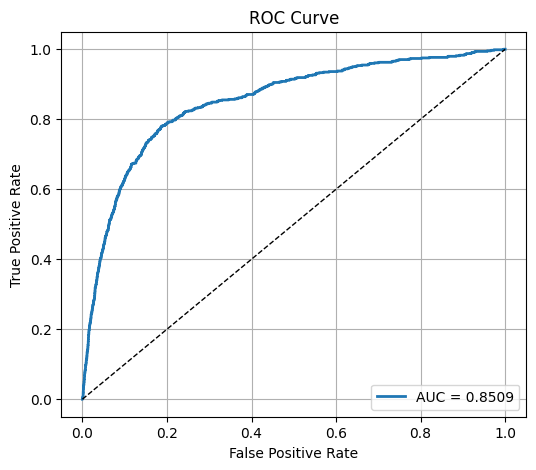

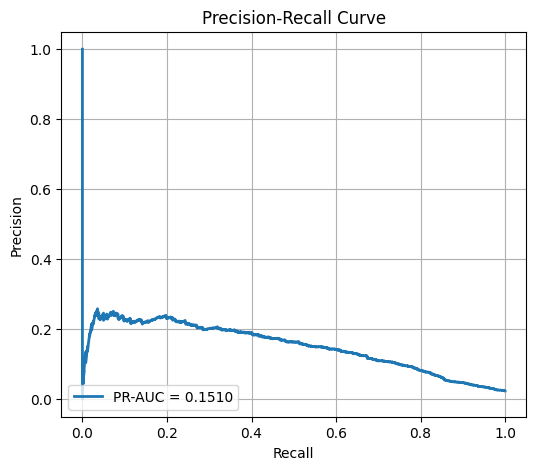

{'roc_auc': 0.8509468941309004,
 'pr_auc': 0.151035045921055,
 'precision@k': {'1': 0.0,
  '3': 0.2119700748129676,
  '5': 0.18937125748502995,
  '10': 0.14328469884025438},
 'recall@k': {'1': 0.0,
  '3': 0.26479750778816197,
  '5': 0.3940809968847352,
  '10': 0.5965732087227414,
  '20': 0.7772585669781932}}

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

def metric_report(y_true, y_pred, ks=(1, 3, 5, 10, 20)):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    order = np.argsort(-y_pred)
    y_true_sorted = y_true[order]

    n = len(y_true)
    total_pos = y_true.sum()

    precision_at_k = {}
    recall_at_k = {}

    for k in ks:
        if k <= 1:
            top_k = k
        else:
            top_k = int(n * (k / 100))

        top_k = max(1, top_k)
        y_top = y_true_sorted[:top_k]

        if k <= 10:
            precision_at_k[str(k)] = y_top.mean()

        if k <= 20:
            recall_at_k[str(k)] = (
                y_top.sum() / total_pos if total_pos > 0 else 0
            )

    fpr, tpr, _ = roc_curve(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", lw=2)
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, lw=2, label=f"PR-AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision@k": precision_at_k,
        "recall@k": recall_at_k
    }

metric_report(y_oot, y_pred_proba, ks=(1, 3, 5, 10, 20))


In [22]:
# КОМПАКТНЫЙ ВАРИАНТ
print("АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*80)
df = data
# Считаем уникальные значения для каждого признака
unique_counts = {}
for col in df.columns:
    if col.startswith('feature_'):
        unique_counts[col] = df[col].nunique()

# Группируем по количеству уникальных значений
from collections import defaultdict
count_groups = defaultdict(list)

for feature, count in unique_counts.items():
    count_groups[count].append(feature)

# Выводим результат
for num_values in range(2, 11):
    features = count_groups.get(num_values, [])
    if features:
        print(f"\nПризнаки с {num_values} уникальными значениями ({len(features)}):")
        for feature in features[:5]:  # показываем только первые 5
            print(f"  - {feature}")
            # Показываем сами значения для первых 3 признаков
            if features.index(feature) < 3:
                values = df[feature].unique()
                print(f"    Значения: {sorted(values)}")
        if len(features) > 5:
            print(f"  ... и еще {len(features) - 5} признаков")

# Самые интересные случаи
print(f"\n{'='*80}")
print("САМЫЕ ИНТЕРЕСНЫЕ СЛУЧАИ:")
print(f"{'='*80}")

for num_values in [2, 3]:
    if num_values in count_groups:
        print(f"\nБинарные/трехзначные признаки ({num_values} значения):")
        for feature in count_groups[num_values][:10]:  # первые 10
            values = df[feature].dropna().unique()
            value_counts = df[feature].value_counts()
            print(f"  {feature}:")
            print(f"    Значения: {sorted(values)}")
            print(f"    Распределение: {dict(value_counts)}")

АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Признаки с 2 уникальными значениями (477):
  - feature_0
    Значения: [-0.3618543, nan, 2.7637558]
  - feature_1
    Значения: [-0.17299719, nan, 5.780886]
  - feature_5
    Значения: [-0.20176533, nan, 4.9566345]
  - feature_7
  - feature_20
  ... и еще 472 признаков

Признаки с 3 уникальными значениями (2):
  - feature_810
    Значения: [nan, -0.003938356, 182.03108, 464.9819]
  - feature_1157
    Значения: [0.0, 1.0, 2.0]

Признаки с 4 уникальными значениями (4):
  - feature_211
    Значения: [0.0, 2.0, nan, 1.0, 3.0]
  - feature_969
    Значения: [0.0, 1.0, 2.0, 3.0]
  - feature_1001
    Значения: [nan, -0.8071072, 10.82344, 22.453987, 34.084534]
  - feature_1218

Признаки с 5 уникальными значениями (6):
  - feature_139
    Значения: [0.0, 1.0, 2.0, 3.0, 4.0]
  - feature_477
    Значения: [nan, -0.19541268, 16.066423, 32.32826, 48.590096, 64.85193]
  - feature_514
    Значения: [0.0, 1.0, 2.0, nan, 3.0, 4.0]
  - feature_733
  - feature_893
  ... и 

In [6]:
data.feature_539.value_counts()

feature_539
-0.803689     412314
 1.207996     169797
 3.219681      26301
 5.231366       4636
 7.243051        979
 9.254735        351
 11.266420       105
 15.289789        51
 13.278105        36
 17.301474        19
Name: count, dtype: int64